In [3]:
import numpy
import torch

from contexttimer import Timer
from matplotlib import pyplot
from more_itertools.recipes import pairwise
from typing import Collection, NamedTuple, Tuple

In [4]:
class Batch(NamedTuple):
    """Represent a batch of tasks, returned by `generate_sinusoid_batch`."""
    x: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    y: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    amplitude: numpy.ndarray  # (batch_size_meta,)
    phase: numpy.ndarray  # (batch_size_meta,)
    input_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]


def generate_sinusoid_batch(
        batch_size_meta: int,
        batch_size_inner: int,
        amplitude_range: Tuple[float, float]=(0.1, 5.0),
        phase_range: Tuple[float, float]=(0., numpy.pi),
        input_range: Tuple[float, float]=(-5.0, 5.0)) -> Batch:
    """Compute a batch of samples.
    
    We draw `batch_size_meta` tasks, and for each task a batch of `batch_size_inner` points. Each "task"
    represents a regression problem, underlied by a sine wave with some amplitude and phase.
    
    Args:
        batch_size_meta: The number of tasks to draw.
        batch_size_inner: The number of samples for each task.
        amplitude_range: Draw the amplitude of the sine wave for the task uniformly from this range.
        phase_range: Draw the phase of the sine wave for the task uniformly from this range.
        input_range: The range from which the input variable will be drawn uniformly.
    """
    amplitude = numpy.random.uniform(amplitude_range[0], amplitude_range[1], batch_size_meta)
    phase = numpy.random.uniform(phase_range[0], phase_range[1], batch_size_meta)
    
    # All input locations are independent.
    x = numpy.random.uniform(
        input_range[0],
        input_range[1],
        (batch_size_meta, batch_size_inner))
    
    # To compute the outputs, we should broadcast the amplitude & phase over all inner samples.
    y = numpy.expand_dims(amplitude, axis=1) * numpy.sin(x - numpy.expand_dims(phase, axis=1))
    
    return Batch(x, y, amplitude, phase, input_range, amplitude_range)


def plot_task(batch: Batch, index: int):
    """Plot the task with the specified `index` from the given `batch`."""
    # Plot the reference curve
    truth_x = numpy.linspace(batch.input_range[0], batch.input_range[1], 200)
    truth_y = batch.amplitude[index] * numpy.sin(truth_x - batch.phase[index])
    pyplot.plot(truth_x, truth_y, c='r', label='truth')
    
    # Plot the sample points.
    pyplot.plot(batch.x[index], batch.y[index], '^', label='samples')
    
    pyplot.xlim(*batch.input_range)
    max_y = max(batch.amplitude_range)
    pyplot.ylim(-max_y, max_y)
    
    pyplot.legend()

In [5]:
batch = generate_sinusoid_batch(3, 5)

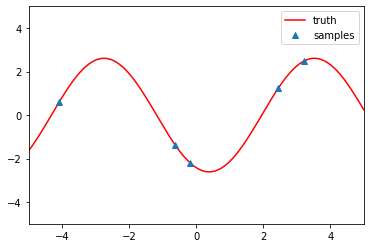

In [6]:
plot_task(batch, 0)

In [11]:
batch.x

array([[-0.6283846 , -0.18770144, -4.09803082,  2.45289938,  3.22124447],
       [ 1.63566076,  4.87131791,  0.48346901, -0.94792303, -0.12155327],
       [ 4.47132699, -3.98549463, -2.14739351, -3.84989929,  0.76371055]])

In [7]:
class SinusoidalRegressor(torch.nn.Module):
    """A module suitable for producing  """
    
    def __init__(self, hidden_sizes: Collection[int]=(40, 40)):
        super().__init__()
        dim_in = 1
        dim_out = 1
        all_dims = (dim_in,) + tuple(hidden_sizes) + (dim_out,)
        self.layers = [torch.nn.Linear(dim_1, dim_2) for dim_1, dim_2 in pairwise(all_dims)]
        
        for i, layer in enumerate(self.layers):
            # Register this as a sub-module, so we declare the existence of the necessary parameters
            torch.nn.init.xavier_normal_(layer.weight)
            self.add_module(f'layer_{i}', layer)
            
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        for layer in self.layers:
            x = layer(x)
            x = self.relu(x)
        return x

In [8]:
def get_device():
    return torch.device('cuda:1')

In [10]:
def train_simple(
        *,
        use_reynolds_trick: bool,
        num_epochs: int=50,
        batch_size: int=1000,
        learning_rate: float=1e-3,
        verbose: bool=False) -> list:
    device = get_device()
    module = SinusoidalRegressor().to(device)
    
    
    # print(model)

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    test_accuracies = []

    numpy.random.seed(42)
    
    with Timer() as timer:
        for i_epoch in range(num_epochs):
            # Shuffle training data
            index = numpy.arange(torch_train_x.shape[0])
            numpy.random.shuffle(index)
            shuffled_train_x = torch_train_x[index]
            shuffled_train_y = torch_train_y[index]

            num_batches = train_X.shape[0] // batch_size
            for i_batch in range(num_batches):
                # Create Tensors to hold inputs and outputs

                i_start = i_batch * batch_size
                i_end = i_start + batch_size
                x = shuffled_train_x[i_start:i_end]
                y = shuffled_train_y[i_start:i_end]

                # Forward pass: Compute predicted y by passing x to the model
                y_pred = model(x)

                # Compute loss
                loss = criterion(y_pred, y)

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # At the end of each epoch print a summary
            acc = accuracy(y_pred, y)

            # No need to accumulate gradients when evaluating the validation loss.
            # Also, we put the model into "evaluation mode" for the purpose of computing the prediction. This is
            # to prevent layers like BatchNorm / Dropout mutating their internal state.
            with torch.no_grad(), model_eval(model):
                test_y_pred = model(torch_test_x)
                test_accuracy = accuracy(test_y_pred, torch_test_y).item()
                
            test_accuracies.append(test_accuracy)
            if verbose:
                print(f'Epoch {i_epoch + 1}/{num_epochs}:   {100 * acc.item():.1f}%   {100 * test_accuracy:.1f}%')

    print(timer)
    return test_accuracies

In [14]:
# From code:
batch_size_meta = 25

# The inner batch size. It seems to vary between plots.
# We actually generate *twice* this amount of data in total; half is used for the inner
# training loop, and the other half for inner testing.
update_batch_size_inner = 10

learning_rate_meta = 0.001  # Meta Adam optimizer
learning_rate_update = 0.001  # Inner Adam optimizer
num_steps_train_meta = 70000